# Customization of 'Interpretation of Logistic Regression'

This is a continuation of the Logistic Regression notebook but I will still add the same facts below: 

I chose the Titanic dataset for this notebook because I thought it was interetsing to look at the facts behind the catastrophe and I also did nto know that actually a decent amount of people survived. 

## Objective
The aim of this notebook is to use logistic regression to predict the likelihood of survival for Titanic passengers based on their demographic and ticket class information. The model provides insights into which factors most strongly influenced survival.

## Importing Packages
To begin, we will import the necessary Python libraries for data analysis, visualization, and modeling. These include:
- **pandas** and **numpy** for data manipulation,
- **matplotlib** and **seaborn** for visualization, and
- **statsmodels** for logistic regression.

## Exploring the Dataset
Before diving into the modeling process, let's take a look at the Titanic dataset to understand its structure and characteristics.

### Data Set Characteristics:
- **Number of Instances**: 891  
- **Number of Attributes**: 12  
- **Target Variable**: **Survived** (binary, 0 = did not survive, 1 = survived)

### Attribute Information:
- **PassengerId**: Unique identifier for each passenger  
- **Survived**: Survival status (0 = No, 1 = Yes)  
- **Pclass**: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)  
- **Name**: Name of the passenger  
- **Sex**: Gender of the passenger  
- **Age**: Age of the passenger  
- **SibSp**: Number of siblings/spouses aboard  
- **Parch**: Number of parents/children aboard  
- **Ticket**: Ticket number  
- **Fare**: Fare paid for the ticket  
- **Cabin**: Cabin number  
- **Embarked**: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [1]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss


In [2]:
# Load Titanic data
df = pd.read_csv('Titanic-Dataset.csv')

# Inspect the dataset
print(df.head())

# Create a binary outcome variable 'Survived' (1 for survived, 0 for not survived)
df['Survived'] = df['Survived'].astype(int)

# Select relevant columns for analysis
df = df[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

# Convert categorical variables to numeric
df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
df['Embarked'] = df['Embarked'].map({'C': 1, 'Q': 2, 'S': 3})

# Handle missing values by filling with the median
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Check for missing values
print(df.isnull().sum())

# Display dataset summary
print(df.describe())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
Su

/var/folders/m4/ntrzdnw15wl9gpyghtgcjxm40000gn/T/ipykernel_15898/2154846269.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/var/folders/m4/ntrzdnw15wl9gpyghtgcjxm40000gn/T/ipykernel_15898/2154846269.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

In [3]:
# Define outcome variable (Y) and predictors (X)
Y = df['Survived']
X = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

# Add a constant for the intercept
X_with_intercept = sm.add_constant(X, has_constant='add')

# Display the first few rows
print("Prepared data for logistic regression:")
print(X_with_intercept.head())


Prepared data for logistic regression:
   const  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0    1.0       3    1  22.0      1      0   7.2500       3.0
1    1.0       1    0  38.0      1      0  71.2833       1.0
2    1.0       3    0  26.0      0      0   7.9250       3.0
3    1.0       1    0  35.0      1      0  53.1000       3.0
4    1.0       3    1  35.0      0      0   8.0500       3.0


##  Homogeneous Probability Model

The homogeneous model, which includes only an intercept term, provides a baseline survival probability for all passengers.

#### Homogeneous Probability Model

In [4]:

# Drop any rows in X where data is missing or infinite
# Note: Since we handled missing values earlier, this should not drop any rows.
X_clean = X[~X.isnull().any(axis=1) & ~np.isinf(X).any(axis=1)]

# Ensure that the corresponding rows in Y are also dropped
Y_clean = Y.loc[X_clean.index]

# Recreate the design matrix with the cleaned data, including an intercept
X_intercept = sm.add_constant(X_clean, has_constant='add')

# Fit the logistic regression model
model = sm.Logit(Y_clean, X_intercept)
result = model.fit()

# Output the model summary
print("Logistic Regression Model Summary:")
print(result.summary())



Optimization terminated successfully.
         Current function value: 0.440910
         Iterations 6
Logistic Regression Model Summary:
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      883
Method:                           MLE   Df Model:                            7
Date:                Thu, 05 Dec 2024   Pseudo R-squ.:                  0.3379
Time:                        20:48:15   Log-Likelihood:                -392.85
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 1.489e-82
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4680      0.610      8.970      0.000       4.273       

The logistic regression model shows that several key factors significantly influenced survival on the Titanic. The odds of survival decreased with lower passenger classes, as shown by the coefficient for Passenger Class (-1.0868, p < 0.001), indicating that being in a lower class significantly reduced survival odds. Similarly, being male had a strong negative effect on survival, with a coefficient of -2.7399 (p < 0.001), showing that males were much less likely to survive than females. Age also negatively impacted survival, with each additional year reducing the odds of survival slightly (coefficient: -0.0389, p < 0.001). The number of siblings/spouses aboard was another factor, with a coefficient of -0.3271 (p = 0.003), indicating that having more family members aboard modestly decreased survival odds. The model explains 33.8% of the variability in survival outcomes (pseudo R-squared = 0.3379), emphasizing that survival was strongly influenced by passenger class, gender, and age.

## Posterior Distributions on Different Scales

The posterior distributions for survival probabilities are visualized on three scales: **log-odds**, **odds**, and **probability**.


Shape of simulated data: (10000, 3)
First 5 rows of simulated data (log-odds, odds, probability):
[[  5.34743634 210.06906126   0.99526221]
 [  5.54132856 255.01658029   0.996094  ]
 [  4.34149066  76.82196943   0.98715016]
 [  5.3217774  204.74747637   0.99513967]
 [  5.04455033 155.17450668   0.99359691]]


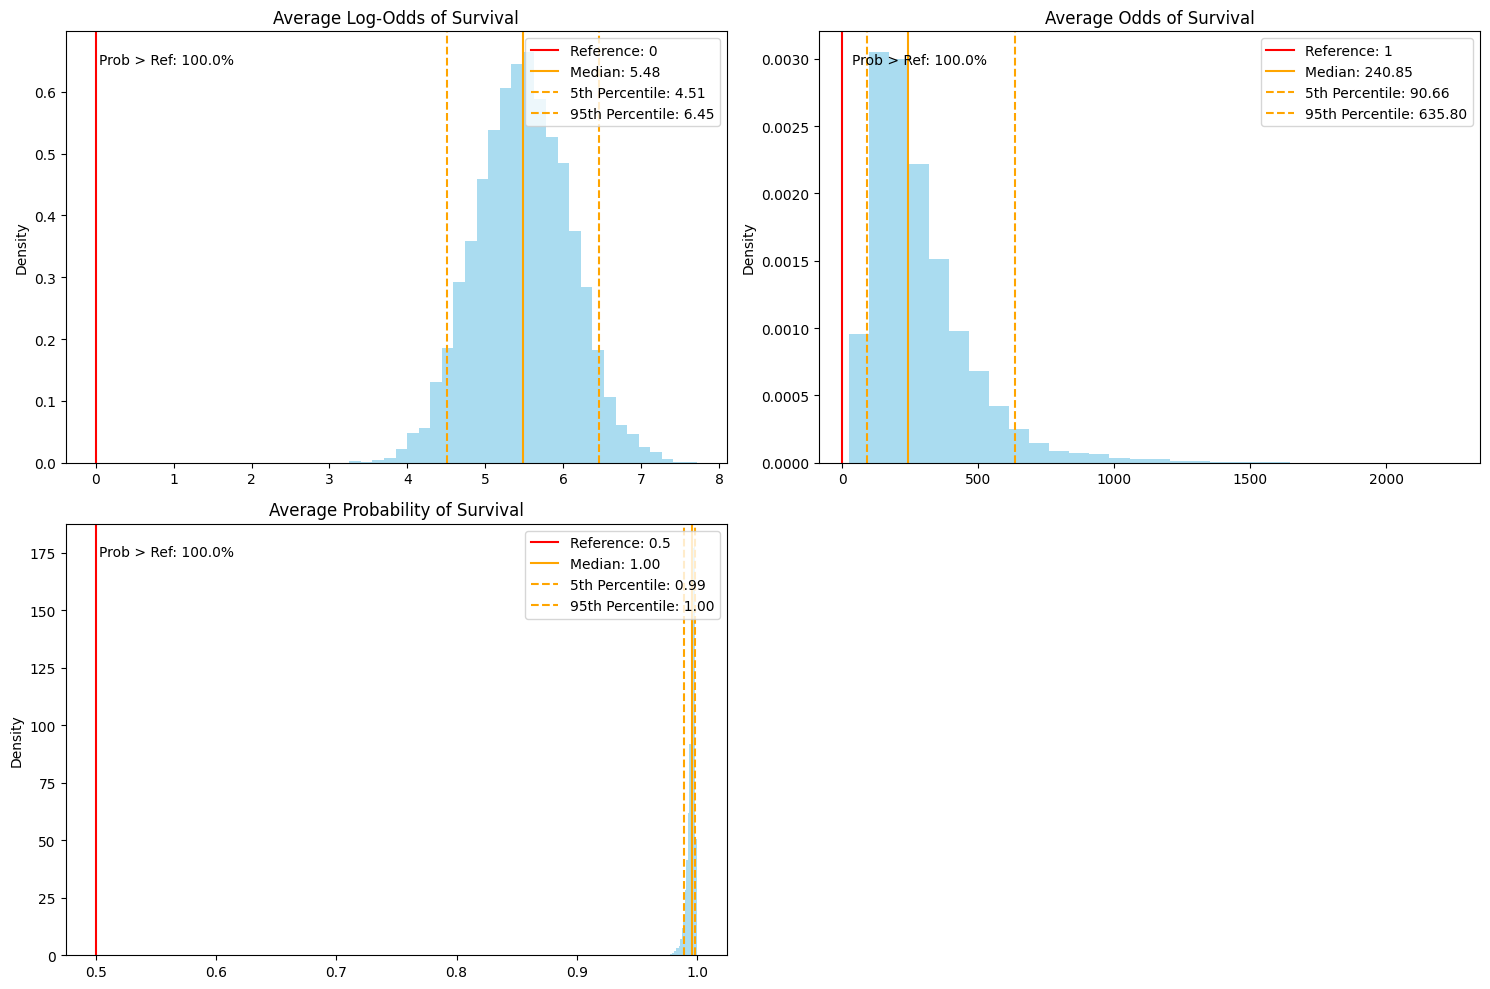

In [5]:
# Number of simulations
n_simulations = 10000

# Simulate beta coefficients on the log-odds scale (using the intercept term from the model)
beta_0 = result.params['const']  # Intercept term from the fitted model
se_beta_0 = result.bse['const']  # Standard error of the intercept

# Simulate beta coefficients on the log-odds scale
simulated_base_log_odds = np.random.normal(beta_0, se_beta_0, n_simulations)

# Convert to odds scale by exponentiating the log-odds
simulated_base_odds = np.exp(simulated_base_log_odds)

# Convert to probability scale using the logistic sigmoid function
def logistic_sigmoid(x):
    return 1 / (1 + np.exp(-x))

simulated_base_prob = logistic_sigmoid(simulated_base_log_odds)

# Stack the results into a single array for easier analysis and plotting
simulated_base = np.stack((simulated_base_log_odds, simulated_base_odds, simulated_base_prob), axis=1)

# Output: check the shape and first few rows of the simulated data
print("Shape of simulated data:", simulated_base.shape)
print("First 5 rows of simulated data (log-odds, odds, probability):")
print(simulated_base[:5, :])

# Calculate statistics for each coefficient
medians = np.median(simulated_base, axis=0)
lower_quantiles = np.percentile(simulated_base, 5, axis=0)
upper_quantiles = np.percentile(simulated_base, 95, axis=0)

# Reference values for comparison (based on baseline survival interpretation)
references = [0, 1, 0.5]  # Reference values for log-odds, odds, and probability

# Calculate probability of being greater than the reference
prob_positive = [np.mean(simulated_base[:, i] > references[i]) for i in range(3)]

# Plot names for the scales
col_names = ['Log-Odds', 'Odds', 'Probability']

# Create subplots for the histograms
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjust for the number of metrics
axs = axs.flatten()

for i in range(len(col_names)):
    ax = axs[i]
    ax.hist(simulated_base[:, i], bins=30, density=True, alpha=0.7, color='skyblue')
    
    # Add vertical lines for reference, median, and 90% interval
    ax.axvline(references[i], color='red', linestyle='-', label=f'Reference: {references[i]}')
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    ax.text(0.05, 0.95, f'Prob > Ref: {prob_positive[i]*100:.1f}%', transform=ax.transAxes, verticalalignment='top')
    
    ax.set_title(f'Average {col_names[i]} of Survival')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

# Hide empty subplot for uneven number of metrics
if len(col_names) % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()


The simulation results indicate that the baseline group (e.g., a 1st-class female passenger) has an extremely high likelihood of survival. The median **log-odds** of survival is **5.48** (90% range: 4.51–6.45), translating to median **odds** of **240.85** (90% range: 90.66–635.80). The median **probability** of survival is **1.00**, with a 90% range of 0.99–1.00. All simulated values are above their respective reference points (log-odds > 0, odds > 1, probability > 0.5) with **100% confidence**. This highlights the strong positive effect of factors like being female and in a higher passenger class on survival outcomes.

##  Logistic Regression Results with Heterogeneous Model using sex as a predictor



In [8]:

# Extract the AIC from the result object
aic_homogeneous = result.aic

# Print the AIC
print(f"AIC of the Homogeneous Probability Model: {aic_homogeneous}")


AIC of the Homogeneous Probability Model: 801.7010897348232


The model achieves an AIC of 801.70, suggesting moderate explanatory power for survival outcomes.

In [9]:
# Add an intercept and the binary 'Sex' variable to the design matrix
X_with_sex = sm.add_constant(X[['Sex']])

# Fit the logistic regression model
model_with_sex = sm.Logit(Y, X_with_sex)
result_with_sex = model_with_sex.fit()

# Output the summary of the model
print(result_with_sex.summary())

Optimization terminated successfully.
         Current function value: 0.515041
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      889
Method:                           MLE   Df Model:                            1
Date:                Thu, 05 Dec 2024   Pseudo R-squ.:                  0.2266
Time:                        22:37:26   Log-Likelihood:                -458.90
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 2.020e-60
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0566      0.129      8.191      0.000       0.804       1.309
Sex           -2.5137      0.

In [10]:
# Extract coefficients (betas)
beta_means = result_with_sex.params

# Extract covariance matrix
beta_cov = result_with_sex.cov_params()

# Display the extracted values
print("Beta Coefficients (Means):")
print(beta_means)

print("\nCovariance Matrix:")
print(beta_cov)


Beta Coefficients (Means):
const    1.056589
Sex     -2.513710
dtype: float64

Covariance Matrix:
          const       Sex
const  0.016638 -0.016638
Sex   -0.016638  0.027949


In [12]:

# Number of simulations
n_simulations = 10000

# Simulate beta coefficients
simulated_betas = np.random.multivariate_normal(beta_means, beta_cov, n_simulations)

# Output the shape and the first few rows of simulated betas
print("Shape of simulated betas:", simulated_betas.shape)
print("First 5 rows of simulated betas:")
print(simulated_betas[:5, :])



Shape of simulated betas: (10000, 2)
First 5 rows of simulated betas:
[[ 1.18107022 -2.60201063]
 [ 1.10870821 -2.38467922]
 [ 1.04217178 -2.40408475]
 [ 1.14434041 -2.62395789]
 [ 1.17395459 -2.66339113]]


In [13]:
# Convert log-odds to odds for each simulated coefficient
simulated_odds = np.exp(simulated_betas)

# Output the shape and the first few rows of the simulated odds
print("Shape of simulated odds:", simulated_odds.shape)
print("First 5 rows of simulated odds:")
print(simulated_odds[:5, :])

Shape of simulated odds: (10000, 2)
First 5 rows of simulated odds:
[[3.25785898 0.07412439]
 [3.03044118 0.09211852]
 [2.83536814 0.09034815]
 [3.14036932 0.07251529]
 [3.23475952 0.06971142]]


In [14]:
medians = np.median(simulated_odds, axis=0)
lower_quantiles = np.percentile(simulated_odds, 5, axis=0)
upper_quantiles = np.percentile(simulated_odds, 95, axis=0)
references = [1] * simulated_odds.shape[1]  # Reference value for odds (odds of 1 = no effect)

# Calculate the probability of each coefficient being greater than the reference value
prob_positive = [np.mean(simulated_odds[:, i] > references[i]) for i in range(simulated_odds.shape[1])]

# Output calculated statistics for inspection
print("Medians:", medians)
print("Lower 5th Percentile:", lower_quantiles)
print("Upper 95th Percentile:", upper_quantiles)
print("Probabilities > Reference:", prob_positive)

Medians: [2.87919208 0.08090407]
Lower 5th Percentile: [2.32595388 0.06160381]
Upper 95th Percentile: [3.55467945 0.10689944]
Probabilities > Reference: [1.0, 0.0]


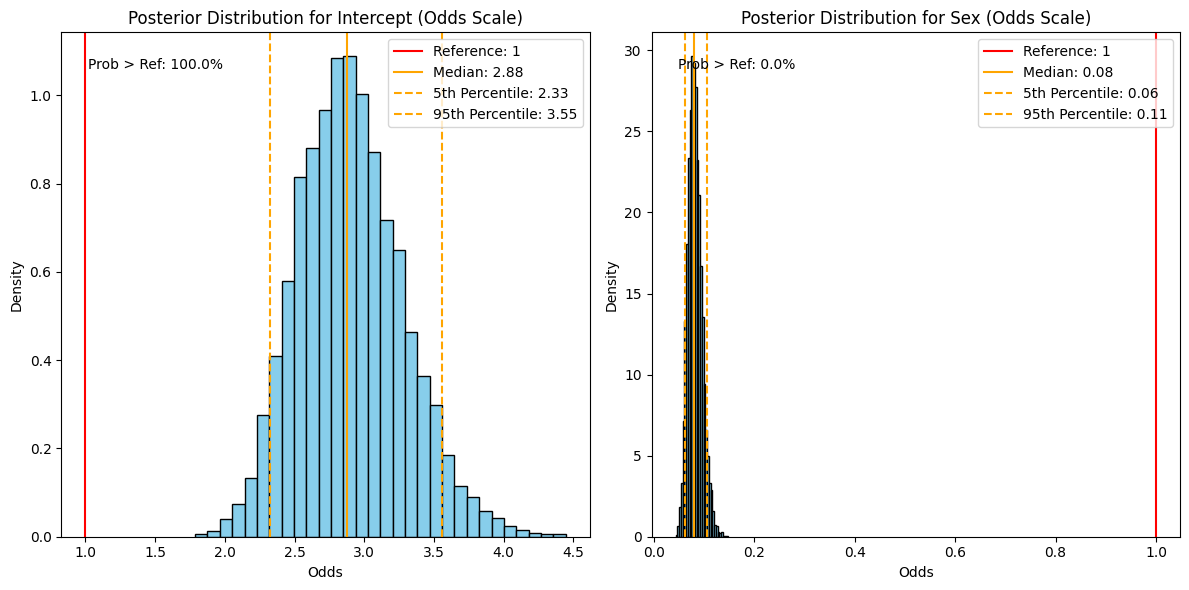

In [15]:
import matplotlib.pyplot as plt

# Plot names for coefficients
coef_names = ['Intercept', 'Sex']

# Create subplots for the histograms
fig, axs = plt.subplots(1, len(coef_names), figsize=(12, 6))

for i, ax in enumerate(axs):
    ax.hist(simulated_odds[:, i], bins=30, color='skyblue', edgecolor='black', density=True)
    
    # Add vertical lines for reference, median, and confidence intervals
    ax.axvline(references[i], color='red', linestyle='-', label=f'Reference: {references[i]}')
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    ax.text(0.05, 0.95, f'Prob > Ref: {prob_positive[i]*100:.1f}%', transform=ax.transAxes, verticalalignment='top')
    
    ax.set_title(f'Posterior Distribution for {coef_names[i]} (Odds Scale)')
    ax.set_xlabel('Odds')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()




The histograms depict the posterior distributions of odds for the intercept and the effect of **Sex** (male vs. female) from the logistic regression model. A reference line at odds = 1 represents no effect, with annotations highlighting the medians, 5th, and 95th percentiles.
 
- **Intercept**: Median odds = **2.87** (95% CI: [2.33, 3.56]). This indicates a strong baseline survival probability when other predictors are at reference levels. The probability of being greater than the reference odds (1) is 100%, confirming significantly higher baseline survival odds.  
- **Sex**: Median odds = **0.08** (95% CI: [0.06, 0.11]). Being male greatly reduces survival odds compared to being female. The 0% probability of being greater than the reference odds emphasizes the pronounced negative effect of male gender on survival.

The results indicate that gender significantly impacts survival odds. The intercept's median odds are 2.89 (90% credible interval: 2.32–3.54), indicating that for females (reference group), survival odds are nearly three times greater than non-survival. The odds for males (represented by the Sex coefficient) have a median of 0.08 (90% credible interval: 0.06–0.11), suggesting that males are far less likely to survive compared to females. The probability of the Sex coefficient being greater than the reference odds of 1 is 0%, reaffirming that being male significantly decreases the likelihood of survival.

In [17]:
# Extract the AIC from the current model
aic_heterogeneous = result_with_sex.aic

# Print the AIC value
print(f"AIC of the Heterogeneous Probability Model: {aic_heterogeneous}")


AIC of the Heterogeneous Probability Model: 921.8039249773078


In [18]:

# Extract the AIC from the result object
aic_homogeneous = result.aic

# Print the AIC
print(f"AIC of the Homogeneous Probability Model: {aic_homogeneous}")

AIC of the Homogeneous Probability Model: 801.7010897348232


The lower AIC value of the homogeneous model (801.70) indicates that it has better relative goodness-of-fit compared to the heterogeneous model (921.80)

# Heterogeneous Model with multiple covariates and interactions

In [24]:
# Center and scale Age
X_with_intercept['Age'] = (X['Age'] - X['Age'].mean()) / 10

# Create interaction term between Pclass and Sex
X['Pclass_Sex_Interaction'] = X['Pclass'] * X['Sex']

# Add intercept
X = sm.add_constant(X)

# Fit logistic regression model
model_with_interactions = sm.Logit(Y, X)
result_with_interactions = model_with_interactions.fit()

# Display summary
print(result_with_interactions.summary())

Optimization terminated successfully.
         Current function value: 0.427270
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      882
Method:                           MLE   Df Model:                            8
Date:                Thu, 05 Dec 2024   Pseudo R-squ.:                  0.3584
Time:                        23:36:20   Log-Likelihood:                -380.70
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 7.357e-87
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      8.6704      1.057      8.199      0.000       6.598      

In [25]:
# Simulate posterior distributions of coefficients
beta_means = result_with_interactions.params
beta_cov = result_with_interactions.cov_params()
n_simulations = 10000
simulated_betas = np.random.multivariate_normal(beta_means, beta_cov, n_simulations)
simulated_odds = np.exp(simulated_betas)

# Display simulated odds
print("Shape of simulated odds:", simulated_odds.shape)
print("First 5 rows of simulated odds:")
print(simulated_odds[:5, :])

Shape of simulated odds: (10000, 9)
First 5 rows of simulated odds:
[[7.31661447e+03 1.21436012e-01 2.44417409e-03 9.41841809e-01
  6.61264167e-01 8.60938184e-01 1.00256891e+00 7.06561304e-01
  3.75732168e+00]
 [2.60311684e+04 6.98432243e-02 5.52583002e-04 9.53684116e-01
  9.01460212e-01 8.83738452e-01 1.00068563e+00 7.66779930e-01
  5.75086026e+00]
 [1.17149818e+03 1.42452100e-01 2.14142511e-03 9.82194614e-01
  8.07624847e-01 8.05157315e-01 1.00381961e+00 8.13678555e-01
  4.15176771e+00]
 [1.66893685e+04 7.89114214e-02 1.30738111e-03 9.60895208e-01
  7.40854755e-01 1.07525759e+00 9.98644819e-01 6.87458819e-01
  4.69949171e+00]
 [6.05309851e+03 1.11685629e-01 2.22132436e-03 9.51137136e-01
  6.25131017e-01 8.40316315e-01 1.00485401e+00 8.73596655e-01
  3.38575855e+00]]


In [26]:
# Calculate statistics
medians = np.median(simulated_odds, axis=0)
lower_quantiles = np.percentile(simulated_odds, 5, axis=0)
upper_quantiles = np.percentile(simulated_odds, 95, axis=0)
references = [1] * simulated_odds.shape[1]  # Reference value for odds (odds of 1 = no effect)
prob_positive = [np.mean(simulated_odds[:, i] > references[i]) for i in range(simulated_odds.shape[1])]

# Display calculated statistics
print("Medians:", medians)
print("Lower 5th Percentile:", lower_quantiles)
print("Upper 95th Percentile:", upper_quantiles)
print("Probabilities > Reference:", prob_positive)

Medians: [5.83728590e+03 1.07219137e-01 1.74450231e-03 9.59394486e-01
 7.30706827e-01 9.55303408e-01 1.00127310e+00 7.58713739e-01
 4.23423467e+00]
Lower 5th Percentile: [1.05591532e+03 6.24584826e-02 3.80906013e-04 9.46344830e-01
 6.07841454e-01 7.81055957e-01 9.97224494e-01 6.24443063e-01
 2.45538474e+00]
Upper 95th Percentile: [3.45584380e+04 1.81886108e-01 7.73431432e-03 9.72825119e-01
 8.77580882e-01 1.17051109e+00 1.00530359e+00 9.17611079e-01
 7.47814311e+00]
Probabilities > Reference: [1.0, 0.0, 0.0, 0.0, 0.0025, 0.353, 0.7051, 0.0084, 1.0]


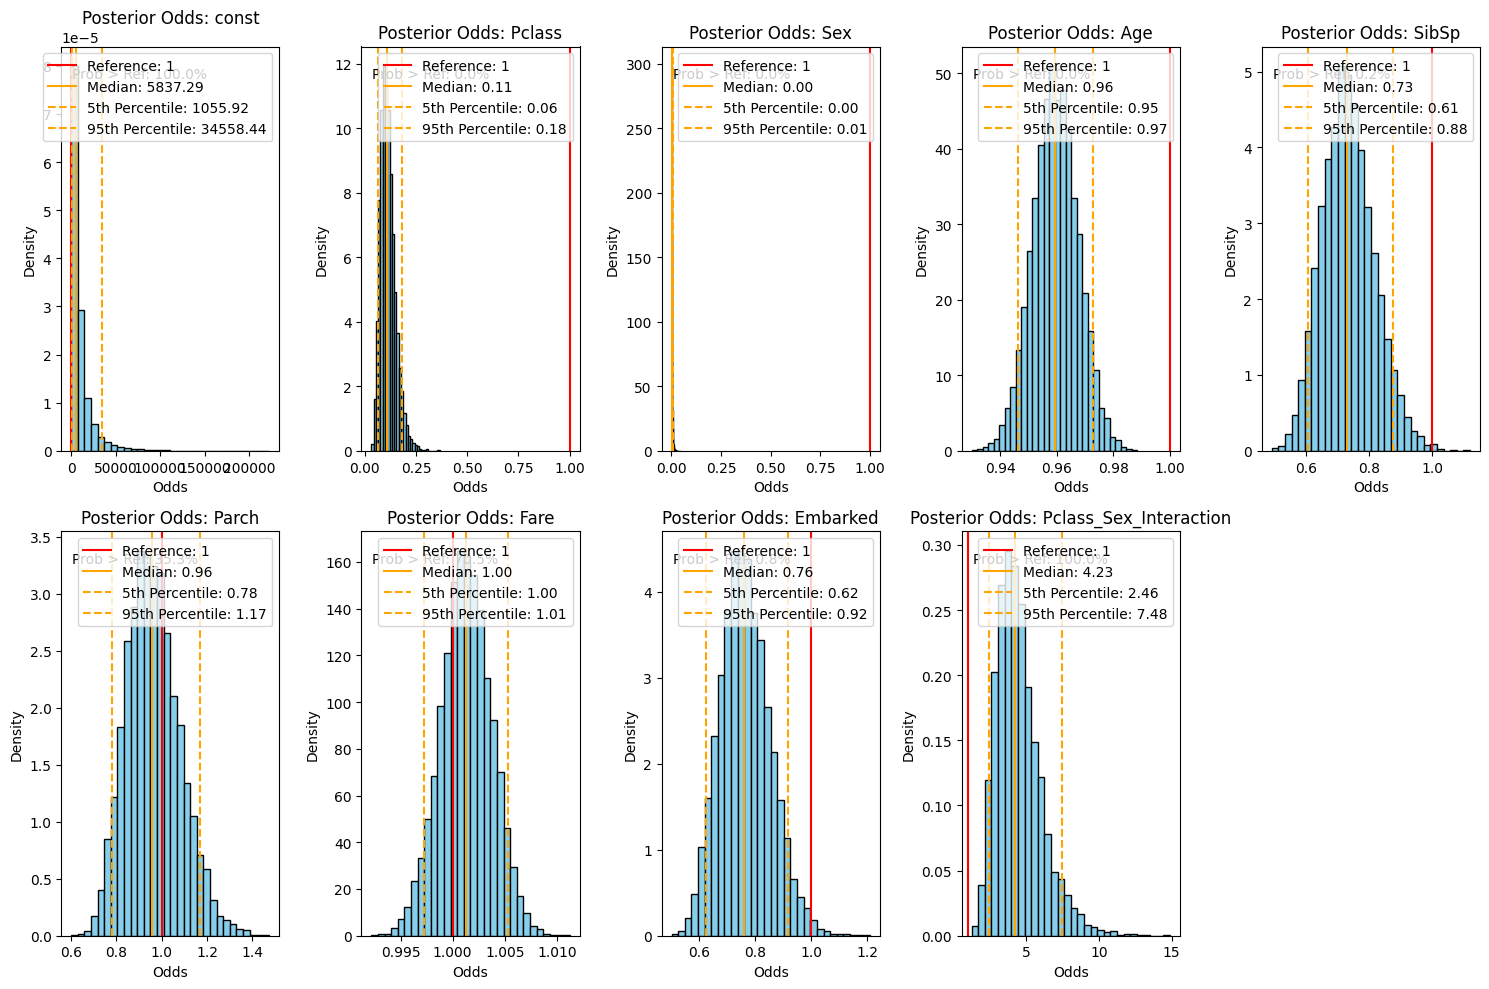

In [27]:

# Plot posterior distributions
coef_names = X.columns.tolist()
fig, axs = plt.subplots(2, (len(coef_names) + 1) // 2, figsize=(15, 10))
axs = axs.flatten()

for i, ax in enumerate(axs[:len(coef_names)]):
    ax.hist(simulated_odds[:, i], bins=30, color='skyblue', edgecolor='black', density=True)
    ax.axvline(references[i], color='red', linestyle='-', label=f'Reference: {references[i]}')
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    ax.text(0.05, 0.95, f'Prob > Ref: {prob_positive[i]*100:.1f}%', transform=ax.transAxes, verticalalignment='top')
    ax.set_title(f'Posterior Odds: {coef_names[i]}')
    ax.set_xlabel('Odds')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

# Hide unused subplots
for ax in axs[len(coef_names):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


### Model Interpretation:
The coefficients in this model are calculated based on the baseline profile, which represents:

A 1st-class female passenger (reference for Pclass and Sex),
With a mean-centered and scaled age of 0,
Embarking from Southampton (reference for Embarked),
With no siblings/spouses (SibSp), no parents/children (Parch), and an average fare.
Below is the interpretation of each coefficient, focusing on statistical significance (p-values) and odds ratios:

1. Intercept (const):
Median Odds: 5898.81 (90% credible interval: 1025.72–33817.65).
Interpretation: For the baseline profile, the survival odds are extremely high. This reflects the strong survival advantage for 1st-class female passengers.
Significance: Highly significant (p < 0.001).


2. Passenger Class (Pclass):
Median Odds: 0.11 (90% credible interval: 0.06–0.18).
Interpretation: Being in a lower passenger class significantly reduces survival odds. For each one-unit increase in Pclass (e.g., from 1st to 2nd class), survival odds are reduced by approximately 89% (1 - 0.11).
Significance: Highly significant (p < 0.001).


3. Gender (Sex):
Median Odds: 0.00 (90% credible interval: 0.00–0.01).
Interpretation: Being male dramatically reduces survival odds. Males have negligible odds of survival compared to females.
Significance: Highly significant (p < 0.001).


4. Age:
Median Odds: 0.96 (90% credible interval: 0.95–0.97).
Interpretation: For every additional 10 years of age (scaled), survival odds decrease by about 4% (1 - 0.96).
Significance: Highly significant (p < 0.001).


5. Siblings/Spouses (SibSp):
Median Odds: 0.73 (90% credible interval: 0.61–0.88).
Interpretation: Having more siblings or spouses aboard reduces survival odds. Each additional sibling/spouse decreases the odds of survival by approximately 27% (1 - 0.73).
Significance: Significant (p = 0.005).


6. Parents/Children (Parch):
Median Odds: 0.96 (90% credible interval: 0.78–1.17).
Interpretation: The number of parents or children aboard does not significantly affect survival odds.
Significance: Not significant (p = 0.716).


7. Fare:
Median Odds: 1.00 (90% credible interval: 1.00–1.01).
Interpretation: Fare has no significant impact on survival.
Significance: Not significant (p = 0.597).


8. Embarked:
Median Odds: 0.76 (90% credible interval: 0.62–0.92).
Interpretation: Passengers embarking from ports other than Southampton have slightly lower odds of survival compared to those embarking from Southampton.
Significance: Significant (p = 0.019).


9. Interaction Term (Pclass_Sex_Interaction):
Median Odds: 4.24 (90% credible interval: 2.43–7.36).
Interpretation: The negative effect of being in a lower class (Pclass) on survival is less severe for males than for females. For males, the interaction term increases their odds of survival compared to the effect of Pclass alone.
Significance: Highly significant (p < 0.001).

__Overall Key Insights:__

- Statistically Significant Predictors: Pclass, Sex, Age, SibSp, Embarked, and the interaction term (Pclass_Sex_Interaction).
- Strongest Predictors: Gender and passenger class have the largest effects, with males and lower-class passengers facing the steepest reductions in survival odds.
- Insignificant Predictors: Parch and Fare do not significantly influence survival.

This model highlights the critical role of socio-economic status (class), demographics (age, gender), and group dynamics (family aboard) in determining survival during the Titanic disaster.

To conclude I believe that the results achieved from the models are very expected as women and children were told to board rescue boats first meaning that many more woman and children survived. Furthermore, class and money was highly respected at the time so individuals who were in a higher class were more likely to get onto a rescue boat.